In [1]:
# Imports of Pytorch and matplotlib and other supporting modules
 
import math

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd


In [2]:
# Setting default device

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

display(f'{device} is available')

dtype = torch.float
torch.set_default_device(device)

def train_loop(dataloader, model, loss_fn, optimize, epoch):
    """Training loop funciton for non-linear function"""
    model.train()
    training_loss = 0
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        y_pred = y_pred.unsqueeze(1)
        loss = loss_fn(y_pred, y)
        training_loss+=loss.item()

        loss.backward()
        optimize.step()
        optimize.zero_grad()
  
    training_loss /= num_batches
    return training_loss

def val_loop(dataloader, model, loss_fn, epoch):
    """Eval loop function for non-linear function"""
    model.eval()
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X,y in dataloader:
            y_pred = model(X)
            y_pred = y_pred.unsqueeze(1)
            test_loss += loss_fn(y_pred, y).item()
            correct +=(y_pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /=size

    #if epoch % 100 == 0:
    #    display(f"Accuracy: {(100*correct)}%, Avg loss: {test_loss}")

    return test_loss

def cnt_model_params(model):
    """Count model parameters"""
    count = 0
    with torch.no_grad():
        for param in model.parameters():
            count+=param.numel()
    return count

def display_model_info(model_name, model):
    """ Display model information"""
    count = 0
    for module in model.modules():
        if isinstance(module, nn.Module):
            count+=1
    display(model)
    display(f"{model_name}. parameters: {cnt_model_params(model)}")

'cuda is available'

In [3]:
class CosNetwork(nn.Module):
        """First DNN for Cosine function"""
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(1, 12),
                nn.ReLU(),
                nn.Linear(12, 1),
                torch.nn.Flatten(0,1)
            )
        
        def forward(self, x):
              logits = self.linear_relu_stack(x)
              return logits
        
cos_model1 = CosNetwork()
display_model_info("cos_model1", cos_model1)


CosNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=1, bias=True)
    (3): Flatten(start_dim=0, end_dim=1)
  )
)

'cos_model1. parameters: 37'

In [4]:
x, x2 = torch.utils.data.random_split(torch.linspace(-math.pi, math.pi, 20000, dtype=dtype), [16000, 4000], generator=torch.Generator(device=torch.device('cuda')).manual_seed(42))
x, x2 = torch.Tensor([b for idx, b in enumerate(x.dataset) if idx in x.indices]).to(device), torch.Tensor([c for idx, c in enumerate(x2.dataset) if idx in x2.indices]).to(device)
# torch.linspace(-math.pi, math.pi, 10000, dtype=dtype)
y = torch.cos(x)
y2 = torch.cos(x2)

lossy1, lossy2, lossy3 = list(), list(), list()
epochx1, epochx2, epochx3 = list(), list(), list()

loss_fn = torch.nn.MSELoss()
epochs = 100
lr = 1e-2
batch_size=8000
optimizer1 = torch.optim.SGD(cos_model1.parameters(), lr=lr)
train_dataloader = DataLoader(TensorDataset(x.unsqueeze(1),y.unsqueeze(1)), batch_size=batch_size)
val_dataloader = DataLoader(TensorDataset(x2.unsqueeze(1),y2.unsqueeze(1)), batch_size=batch_size)

display("Training on original loss function")
for epoch in range(epochs):
    test_loss = train_loop(train_dataloader, cos_model1, loss_fn, optimizer1, epoch)
    val_loss = val_loop(train_dataloader, cos_model1, loss_fn, epoch)
        
    if epoch % 10 == 0:
        display(f"Epoch {epoch}. Training Loss: {test_loss}. Eval Loss: {val_loss}")

'Training on original loss function'

'Epoch 0. Training Loss: 0.5449806153774261. Eval Loss: 0.5205466747283936'

'Epoch 10. Training Loss: 0.39912985265254974. Eval Loss: 0.3899741470813751'

'Epoch 20. Training Loss: 0.31642401218414307. Eval Loss: 0.3093883693218231'

'Epoch 30. Training Loss: 0.251002699136734. Eval Loss: 0.24532080441713333'

'Epoch 40. Training Loss: 0.19772762060165405. Eval Loss: 0.19313375651836395'

'Epoch 50. Training Loss: 0.1543615236878395. Eval Loss: 0.15067623928189278'

'Epoch 60. Training Loss: 0.11943325027823448. Eval Loss: 0.11651739850640297'

'Epoch 70. Training Loss: 0.09177451767027378. Eval Loss: 0.08950631879270077'

'Epoch 80. Training Loss: 0.07030766643583775. Eval Loss: 0.06857378780841827'

'Epoch 90. Training Loss: 0.05398383364081383. Eval Loss: 0.05267809424549341'

In [5]:
from torch.func import functional_call, hessian

def find_tensor(item):
    
    total = []
    if isinstance(item, torch.Tensor):
        
        size = max(item.shape)
        item = item.reshape(size,size)
        eigs_vals = torch.linalg.eigh(item)
        return torch.sum(eigs_vals.eigenvalues > 0).item() / len(eigs_vals)
    else:
        if isinstance(item, dict):
            for key in item:
                total.append(find_tensor(item[key]))
    
    return sum(total)/len(total)
                
        
        

def gradient_norm(model, dataloader, loss_fn, optimize, X,y):
    y_pred = model(X)
    y_pred = y_pred.unsqueeze(1)
    loss = loss_fn(y_pred, y)
    
    grad_all = 0
    for params in model.parameters():
        grad = 0.0
        if params.grad is not None:
            grad = params.grad.detach().cpu().data.norm(2)
            grad_all += grad.item() ** 2
    grad_norm = grad_all ** 0.5
    return grad_norm

def minimum_ratio(model, dataloader, loss_fn, optimize, X,y):
    model.train()
    
    def compute_loss(params):
        y_pred = functional_call(model, params, (X,))
        y_pred = y_pred.unsqueeze(1)
        return nn.functional.mse_loss(y_pred, y).sum()

    vals = 0
    length = 0
    
    
    #y_pred = model(X)
    #y_pred = y_pred.unsqueeze(1)
    #loss = loss_fn(y_pred.unsqueeze(1), y)
    
    hess_fn = hessian(compute_loss)
    weights = {k:v for k,v in model.named_parameters() if 'weight' in k}
    hess = hess_fn(weights)
    return find_tensor(hess)
            
    #display(hess)
    
    #display(type(hess_fn))
    #display(type(hess))
    #display(hess.keys())
    #hess = torch.autograd.functional.hessian(loss_fn, (y_pred.unsqueeze(1), y), create_graph=True)
    #loss.backward()
    #for name, params in model.named_parameters():
    #    if 'weight' in name:
    #        #print(name, len(params), params.shape)
    #        weight = torch.concat((weight, torch.nn.utils.parameters_to_vector(params)))
            
    # params = dict(model.named_parameters())
    # hess = hessian(functional_call)(model, params, (X,))
    
    #display(type(hess))
    #display(hess)
    #eigs_vals, _ = torch.linalg.eigh(hess)
        #display(eigs_vals)
    #vals += torch.sum(eigs_vals > 0).item()
    #length+=len(eigs_vals)
    #return vals/length

def major_loop(dataloader, model, loss_fn, optimize):
    model.train()
    norm_all = []
    min_ratio_all = []
    full_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        y_pred = y_pred.unsqueeze(1)
        loss = loss_fn(y_pred, y)
        #norm = gradient_norm(cos_model1, train_dataloader, loss_fn, optimizer1, X,y)
        #loss = loss_fn(torch.Tensor([norm]).to(device), torch.Tensor([0]).to(device)).to(device)
        #display(loss)
        full_loss +=loss.item()
        loss.backward()
        norm_all.append(gradient_norm(cos_model1, train_dataloader, loss_fn, optimizer1, X,y))
        min_ratio_all.append(minimum_ratio(cos_model1, train_dataloader, loss_fn, optimizer1, X,y))
        optimize.step()
        optimize.zero_grad()
    norm= torch.Tensor(norm_all).mean().item()
    min_ratio = torch.Tensor(min_ratio_all).mean().item()
    full_loss /= len(dataloader)
    
    val_loss = val_loop(val_dataloader, cos_model1, loss_fn, epoch)
    return norm, min_ratio, full_loss, val_loss


In [6]:

x, x2 = torch.utils.data.random_split(torch.linspace(-math.pi, math.pi, 20000, dtype=dtype), [16000, 4000], generator=torch.Generator(device=torch.device('cuda')).manual_seed(42))
x, x2 = torch.Tensor([b for idx, b in enumerate(x.dataset) if idx in x.indices]).to(device), torch.Tensor([c for idx, c in enumerate(x2.dataset) if idx in x2.indices]).to(device)
y = torch.cos(x)
y2 = torch.cos(x2)

batch_size=8000
optimizer1 = torch.optim.SGD(cos_model1.parameters(), lr=lr)
train_dataloader = DataLoader(TensorDataset(x.unsqueeze(1),y.unsqueeze(1)), batch_size=batch_size)    
final_df = pd.DataFrame()
for epoch in range(2000):
    #train_loop(train_dataloader, cos_model1, loss_fn, optimizer1, epoch)
    #norm = gradient_norm(cos_model1, train_dataloader, loss_fn, optimizer1)
    #min_ratio = minimum_ratio(cos_model1, train_dataloader, loss_fn, optimizer1)
    #val_loss = val_loss = val_loop(val_dataloader, cos_model1, loss_fn, epoch)
    results = major_loop(train_dataloader, cos_model1, loss_fn, optimizer1)
    if epoch%10 == 0:
        display(f'Epoch {epoch}: gradient norm: {results[0]}. min_ratio: {results[1]}. training_loss: {results[2]}. val_loss: {results[3]}')
        if final_df.empty:
            final_df = pd.DataFrame((epoch,) +results,index=['epoch', 'gradient', 'min_ratio', 'training_loss', 'val_loss']).T
        else:
            final_df = pd.concat([final_df, pd.DataFrame((epoch,) +results,index=['epoch', 'gradient', 'min_ratio', 'training_loss', 'val_loss']).T])    

'Epoch 0: gradient norm: 0.30266523361206055. min_ratio: 3.75. training_loss: 0.04178836476057768. val_loss: 0.04056181386113167'

'Epoch 10: gradient norm: 0.2608957886695862. min_ratio: 3.5625. training_loss: 0.03279542736709118. val_loss: 0.03189782798290253'

'Epoch 20: gradient norm: 0.2255631983280182. min_ratio: 3.5625. training_loss: 0.02621702291071415. val_loss: 0.025554349645972252'

'Epoch 30: gradient norm: 0.19646137952804565. min_ratio: 3.5625. training_loss: 0.021418762858957052. val_loss: 0.020921582356095314'

'Epoch 40: gradient norm: 0.17321264743804932. min_ratio: 3.5625. training_loss: 0.01791155058890581. val_loss: 0.01752939261496067'

'Epoch 50: gradient norm: 0.15519118309020996. min_ratio: 3.625. training_loss: 0.015329714282415807. val_loss: 0.015027201734483242'

'Epoch 60: gradient norm: 0.14164432883262634. min_ratio: 3.75. training_loss: 0.013406950631178916. val_loss: 0.013159829191863537'

'Epoch 70: gradient norm: 0.13159382343292236. min_ratio: 3.75. training_loss: 0.011952005559578538. val_loss: 0.011744005605578423'

'Epoch 80: gradient norm: 0.12401340901851654. min_ratio: 3.75. training_loss: 0.010829388280399144. val_loss: 0.010649899020791054'

'Epoch 90: gradient norm: 0.11808803677558899. min_ratio: 3.8125. training_loss: 0.009943991550244391. val_loss: 0.009786266833543777'

'Epoch 100: gradient norm: 0.11322762072086334. min_ratio: 3.8125. training_loss: 0.009229410556145012. val_loss: 0.009089245460927486'

'Epoch 110: gradient norm: 0.10901661217212677. min_ratio: 3.75. training_loss: 0.008639462059363723. val_loss: 0.008514299057424068'

'Epoch 120: gradient norm: 0.1052323579788208. min_ratio: 3.8125. training_loss: 0.008141985046677291. val_loss: 0.008030468598008156'

'Epoch 130: gradient norm: 0.10169240087270737. min_ratio: 4.0625. training_loss: 0.007714577368460596. val_loss: 0.007615937385708094'

'Epoch 140: gradient norm: 0.09831476211547852. min_ratio: 3.875. training_loss: 0.007341744960285723. val_loss: 0.007255219388753176'

'Epoch 150: gradient norm: 0.0950794667005539. min_ratio: 4.0625. training_loss: 0.007012348971329629. val_loss: 0.00693754805251956'

'Epoch 160: gradient norm: 0.09195630252361298. min_ratio: 4.0. training_loss: 0.006718422984704375. val_loss: 0.006655050441622734'

'Epoch 170: gradient norm: 0.08892682194709778. min_ratio: 4.0625. training_loss: 0.006454011774621904. val_loss: 0.006402085069566965'

'Epoch 180: gradient norm: 0.08596336841583252. min_ratio: 3.875. training_loss: 0.006214832654222846. val_loss: 0.006174027919769287'

'Epoch 190: gradient norm: 0.08308783173561096. min_ratio: 4.0625. training_loss: 0.005997520755045116. val_loss: 0.005967554170638323'

'Epoch 200: gradient norm: 0.08030067384243011. min_ratio: 4.0625. training_loss: 0.005799446487799287. val_loss: 0.0057799313217401505'

'Epoch 210: gradient norm: 0.07759733498096466. min_ratio: 4.0625. training_loss: 0.005618397030048072. val_loss: 0.00560902152210474'

'Epoch 220: gradient norm: 0.0749761238694191. min_ratio: 3.875. training_loss: 0.005452596582472324. val_loss: 0.005452936049550772'

'Epoch 230: gradient norm: 0.07244887948036194. min_ratio: 3.8125. training_loss: 0.005300522432662547. val_loss: 0.0053101531229913235'

'Epoch 240: gradient norm: 0.0700080543756485. min_ratio: 4.0625. training_loss: 0.0051607933128252625. val_loss: 0.005179387517273426'

'Epoch 250: gradient norm: 0.06764734536409378. min_ratio: 3.9375. training_loss: 0.005032259155996144. val_loss: 0.005059444345533848'

'Epoch 260: gradient norm: 0.06537321209907532. min_ratio: 4.0. training_loss: 0.004913923563435674. val_loss: 0.0049492535181343555'

'Epoch 270: gradient norm: 0.06318724900484085. min_ratio: 4.0625. training_loss: 0.004804840194992721. val_loss: 0.004847940523177385'

'Epoch 280: gradient norm: 0.06108330935239792. min_ratio: 3.8125. training_loss: 0.004704174469225109. val_loss: 0.004754683934152126'

'Epoch 290: gradient norm: 0.059061698615550995. min_ratio: 4.0. training_loss: 0.004611180163919926. val_loss: 0.004668772220611572'

'Epoch 300: gradient norm: 0.05711165815591812. min_ratio: 3.8125. training_loss: 0.004525161231867969. val_loss: 0.004589552991092205'

'Epoch 310: gradient norm: 0.055237915366888046. min_ratio: 3.5. training_loss: 0.004445556434802711. val_loss: 0.004516367334872484'

'Epoch 320: gradient norm: 0.05344019830226898. min_ratio: 3.75. training_loss: 0.004371830960735679. val_loss: 0.004448646679520607'

'Epoch 330: gradient norm: 0.051723677664995193. min_ratio: 3.875. training_loss: 0.004303459078073502. val_loss: 0.0043859463185071945'

'Epoch 340: gradient norm: 0.05007192865014076. min_ratio: 3.5625. training_loss: 0.004239954520016909. val_loss: 0.004327829927206039'

'Epoch 350: gradient norm: 0.04848664253950119. min_ratio: 3.6875. training_loss: 0.0041809347458183765. val_loss: 0.004273856524378061'

'Epoch 360: gradient norm: 0.046968840062618256. min_ratio: 3.75. training_loss: 0.004126013373024762. val_loss: 0.004223667085170746'

'Epoch 370: gradient norm: 0.04551436007022858. min_ratio: 4.0. training_loss: 0.004074826254509389. val_loss: 0.0041769640520215034'

'Epoch 380: gradient norm: 0.04411927983164787. min_ratio: 3.625. training_loss: 0.004027040733490139. val_loss: 0.0041334619745612144'

'Epoch 390: gradient norm: 0.04277985543012619. min_ratio: 3.6875. training_loss: 0.003982376481872052. val_loss: 0.0040928819216787815'

'Epoch 400: gradient norm: 0.041496582329273224. min_ratio: 3.6875. training_loss: 0.003940589900594205. val_loss: 0.004054944030940533'

'Epoch 410: gradient norm: 0.04026523977518082. min_ratio: 3.625. training_loss: 0.003901426855009049. val_loss: 0.004019445739686489'

'Epoch 420: gradient norm: 0.039083514362573624. min_ratio: 3.5. training_loss: 0.003864667087327689. val_loss: 0.003986185882240534'

'Epoch 430: gradient norm: 0.03794732689857483. min_ratio: 3.5. training_loss: 0.003830125613603741. val_loss: 0.0039549535140395164'

'Epoch 440: gradient norm: 0.036856669932603836. min_ratio: 3.875. training_loss: 0.003797624900471419. val_loss: 0.003925573080778122'

'Epoch 450: gradient norm: 0.03581422567367554. min_ratio: 3.8125. training_loss: 0.003766991605516523. val_loss: 0.0038979037199169397'

'Epoch 460: gradient norm: 0.03481048718094826. min_ratio: 3.6875. training_loss: 0.003738072409760207. val_loss: 0.0038718010764569044'

'Epoch 470: gradient norm: 0.03384394571185112. min_ratio: 3.8125. training_loss: 0.0037107531097717583. val_loss: 0.0038471019361168146'

'Epoch 480: gradient norm: 0.03291960805654526. min_ratio: 3.625. training_loss: 0.0036849025054834783. val_loss: 0.0038237045519053936'

'Epoch 490: gradient norm: 0.032030314207077026. min_ratio: 3.8125. training_loss: 0.0036604002816602588. val_loss: 0.0038014999590814114'

'Epoch 500: gradient norm: 0.031175987794995308. min_ratio: 3.5625. training_loss: 0.003637146146502346. val_loss: 0.0037803873419761658'

'Epoch 510: gradient norm: 0.030357595533132553. min_ratio: 3.875. training_loss: 0.0036150403320789337. val_loss: 0.003760281717404723'

'Epoch 520: gradient norm: 0.029570894315838814. min_ratio: 3.5625. training_loss: 0.0035939881927333772. val_loss: 0.003741113469004631'

'Epoch 530: gradient norm: 0.02881358563899994. min_ratio: 3.625. training_loss: 0.003573911264538765. val_loss: 0.0037228032015264034'

'Epoch 540: gradient norm: 0.02808757871389389. min_ratio: 3.75. training_loss: 0.003554736147634685. val_loss: 0.003705292008817196'

'Epoch 550: gradient norm: 0.02738996595144272. min_ratio: 3.9375. training_loss: 0.003536384378094226. val_loss: 0.003688530530780554'

'Epoch 560: gradient norm: 0.02671976387500763. min_ratio: 3.625. training_loss: 0.0035187844187021255. val_loss: 0.003672473831102252'

'Epoch 570: gradient norm: 0.026073593646287918. min_ratio: 3.75. training_loss: 0.003501894767396152. val_loss: 0.003657055087387562'

'Epoch 580: gradient norm: 0.02545056864619255. min_ratio: 3.8125. training_loss: 0.0034856664133258164. val_loss: 0.003642225870862603'

'Epoch 590: gradient norm: 0.024852003902196884. min_ratio: 3.625. training_loss: 0.0034700497635640204. val_loss: 0.0036279456689953804'

'Epoch 600: gradient norm: 0.02427348680794239. min_ratio: 3.6875. training_loss: 0.0034550026175566018. val_loss: 0.0036141760647296906'

'Epoch 610: gradient norm: 0.02371923066675663. min_ratio: 3.4375. training_loss: 0.003440483007580042. val_loss: 0.00360088306479156'

'Epoch 620: gradient norm: 0.023182610049843788. min_ratio: 3.5625. training_loss: 0.003426464681979269. val_loss: 0.0035880201030522585'

'Epoch 630: gradient norm: 0.022667236626148224. min_ratio: 3.6875. training_loss: 0.003412909631151706. val_loss: 0.0035755650606006384'

'Epoch 640: gradient norm: 0.022168375551700592. min_ratio: 3.875. training_loss: 0.0033997881109826267. val_loss: 0.0035634906962513924'

'Epoch 650: gradient norm: 0.021688546985387802. min_ratio: 3.625. training_loss: 0.0033870735205709934. val_loss: 0.0035517713986337185'

'Epoch 660: gradient norm: 0.02122362144291401. min_ratio: 3.625. training_loss: 0.003374736523255706. val_loss: 0.003540388075634837'

'Epoch 670: gradient norm: 0.020776033401489258. min_ratio: 3.5. training_loss: 0.003362756338901818. val_loss: 0.0035293190740048885'

'Epoch 680: gradient norm: 0.02034355327486992. min_ratio: 3.75. training_loss: 0.0033511118381284177. val_loss: 0.0035185394808650017'

'Epoch 690: gradient norm: 0.01992720738053322. min_ratio: 3.6875. training_loss: 0.00333977717673406. val_loss: 0.003508043708279729'

'Epoch 700: gradient norm: 0.01952246017754078. min_ratio: 3.625. training_loss: 0.003328737453557551. val_loss: 0.0034978098701685667'

'Epoch 710: gradient norm: 0.019132748246192932. min_ratio: 3.4375. training_loss: 0.0033179810270667076. val_loss: 0.0034878167789429426'

'Epoch 720: gradient norm: 0.0187545046210289. min_ratio: 3.75. training_loss: 0.003307486593257636. val_loss: 0.0034780551213771105'

'Epoch 730: gradient norm: 0.018391631543636322. min_ratio: 3.5625. training_loss: 0.0032972400658763945. val_loss: 0.0034685174468904734'

'Epoch 740: gradient norm: 0.018037624657154083. min_ratio: 3.4375. training_loss: 0.003287230560090393. val_loss: 0.00345918582752347'

'Epoch 750: gradient norm: 0.01769404113292694. min_ratio: 3.625. training_loss: 0.0032774426508694887. val_loss: 0.003450053511187434'

'Epoch 760: gradient norm: 0.017363104969263077. min_ratio: 3.6875. training_loss: 0.0032678746501915157. val_loss: 0.003441097680479288'

'Epoch 770: gradient norm: 0.017041271552443504. min_ratio: 3.5. training_loss: 0.0032585111912339926. val_loss: 0.003432316705584526'

'Epoch 780: gradient norm: 0.016730481758713722. min_ratio: 3.625. training_loss: 0.0032493392354808748. val_loss: 0.0034237047657370567'

'Epoch 790: gradient norm: 0.01642906293272972. min_ratio: 3.625. training_loss: 0.0032403531367890537. val_loss: 0.0034152513835579157'

'Epoch 800: gradient norm: 0.016135338693857193. min_ratio: 3.375. training_loss: 0.0032315413118340075. val_loss: 0.003406953066587448'

'Epoch 810: gradient norm: 0.015852047130465508. min_ratio: 3.5625. training_loss: 0.003222893865313381. val_loss: 0.0033988049253821373'

'Epoch 820: gradient norm: 0.015575450845062733. min_ratio: 3.4375. training_loss: 0.003214407595805824. val_loss: 0.0033907974138855934'

'Epoch 830: gradient norm: 0.015306876972317696. min_ratio: 3.5. training_loss: 0.0032060747616924345. val_loss: 0.0033829256426542997'

'Epoch 840: gradient norm: 0.015047506429255009. min_ratio: 3.6875. training_loss: 0.0031978930346667767. val_loss: 0.003375174943357706'

'Epoch 850: gradient norm: 0.014795812778174877. min_ratio: 3.5625. training_loss: 0.003189848270267248. val_loss: 0.0033675548620522022'

'Epoch 860: gradient norm: 0.014550535939633846. min_ratio: 3.4375. training_loss: 0.0031819332507438958. val_loss: 0.0033600619062781334'

'Epoch 870: gradient norm: 0.014311673119664192. min_ratio: 3.6875. training_loss: 0.0031741508282721043. val_loss: 0.0033526804763823748'

'Epoch 880: gradient norm: 0.014080219902098179. min_ratio: 3.5625. training_loss: 0.0031664922717027366. val_loss: 0.00334541336633265'

'Epoch 890: gradient norm: 0.01385306753218174. min_ratio: 3.375. training_loss: 0.00315895676612854. val_loss: 0.003338247537612915'

'Epoch 900: gradient norm: 0.013633236289024353. min_ratio: 3.5625. training_loss: 0.0031515334849245846. val_loss: 0.0033311902079731226'

'Epoch 910: gradient norm: 0.013418737798929214. min_ratio: 3.5625. training_loss: 0.0031442242325283587. val_loss: 0.0033242283388972282'

'Epoch 920: gradient norm: 0.013210826553404331. min_ratio: 3.8125. training_loss: 0.00313702569110319. val_loss: 0.0033173623960465193'

'Epoch 930: gradient norm: 0.013007010333240032. min_ratio: 3.375. training_loss: 0.0031299327383749187. val_loss: 0.0033105872571468353'

'Epoch 940: gradient norm: 0.01280998159199953. min_ratio: 3.375. training_loss: 0.0031229372834786773. val_loss: 0.0033039057161659002'

'Epoch 950: gradient norm: 0.01261775940656662. min_ratio: 3.4375. training_loss: 0.0031160397338680923. val_loss: 0.0032973105553537607'

'Epoch 960: gradient norm: 0.012430700473487377. min_ratio: 3.5625. training_loss: 0.0031092333956621587. val_loss: 0.0032908101566135883'

'Epoch 970: gradient norm: 0.012250262312591076. min_ratio: 3.5625. training_loss: 0.003102514718193561. val_loss: 0.0032843986991792917'

'Epoch 980: gradient norm: 0.012074263766407967. min_ratio: 3.625. training_loss: 0.0030958783463574946. val_loss: 0.0032780729234218597'

'Epoch 990: gradient norm: 0.01189885102212429. min_ratio: 3.5. training_loss: 0.0030893299845047295. val_loss: 0.003271822351962328'

'Epoch 1000: gradient norm: 0.01172545738518238. min_ratio: 3.6875. training_loss: 0.0030828698654659092. val_loss: 0.003265641164034605'

'Epoch 1010: gradient norm: 0.011558805592358112. min_ratio: 3.6875. training_loss: 0.003076499153394252. val_loss: 0.003259523306041956'

'Epoch 1020: gradient norm: 0.011397854425013065. min_ratio: 3.625. training_loss: 0.00307020649779588. val_loss: 0.0032534776255488396'

'Epoch 1030: gradient norm: 0.011241101659834385. min_ratio: 3.625. training_loss: 0.0030639899196103215. val_loss: 0.0032475029584020376'

'Epoch 1040: gradient norm: 0.01108517311513424. min_ratio: 3.75. training_loss: 0.0030578511068597436. val_loss: 0.003241588594391942'

'Epoch 1050: gradient norm: 0.010933230631053448. min_ratio: 3.5625. training_loss: 0.0030517886043526232. val_loss: 0.003235735697671771'

'Epoch 1060: gradient norm: 0.010787243954837322. min_ratio: 3.375. training_loss: 0.003045797988306731. val_loss: 0.003229947295039892'

'Epoch 1070: gradient norm: 0.010645154863595963. min_ratio: 3.8125. training_loss: 0.0030398733797483146. val_loss: 0.0032242217566818'

'Epoch 1080: gradient norm: 0.01050257682800293. min_ratio: 3.5. training_loss: 0.0030340171651914716. val_loss: 0.0032185555901378393'

'Epoch 1090: gradient norm: 0.010368438437581062. min_ratio: 3.5625. training_loss: 0.0030282276566140354. val_loss: 0.0032129501923918724'

'Epoch 1100: gradient norm: 0.01023421622812748. min_ratio: 3.375. training_loss: 0.0030224976944737136. val_loss: 0.0032074071932584047'

'Epoch 1110: gradient norm: 0.010102801956236362. min_ratio: 3.625. training_loss: 0.003016832924913615. val_loss: 0.003201915416866541'

'Epoch 1120: gradient norm: 0.009975682944059372. min_ratio: 3.5625. training_loss: 0.003011230146512389. val_loss: 0.003196475561708212'

'Epoch 1130: gradient norm: 0.009851385839283466. min_ratio: 3.4375. training_loss: 0.0030056859250180423. val_loss: 0.0031910911202430725'

'Epoch 1140: gradient norm: 0.00972919724881649. min_ratio: 3.5625. training_loss: 0.0030001989216543734. val_loss: 0.003185758600011468'

'Epoch 1150: gradient norm: 0.009611480869352818. min_ratio: 3.625. training_loss: 0.0029947683797217906. val_loss: 0.0031804784666746855'

'Epoch 1160: gradient norm: 0.009498640894889832. min_ratio: 3.5625. training_loss: 0.002989391330629587. val_loss: 0.0031752511858940125'

'Epoch 1170: gradient norm: 0.009386833757162094. min_ratio: 3.5. training_loss: 0.0029840617207810283. val_loss: 0.003170079318806529'

'Epoch 1180: gradient norm: 0.009278079494833946. min_ratio: 3.3125. training_loss: 0.0029787810635752976. val_loss: 0.003164959605783224'

'Epoch 1190: gradient norm: 0.009171444922685623. min_ratio: 3.375. training_loss: 0.0029735502903349698. val_loss: 0.0031598908826708794'

'Epoch 1200: gradient norm: 0.00907039176672697. min_ratio: 3.4375. training_loss: 0.002968362416140735. val_loss: 0.003154876409098506'

'Epoch 1210: gradient norm: 0.008966713212430477. min_ratio: 3.625. training_loss: 0.0029632176738232374. val_loss: 0.0031499129254370928'

'Epoch 1220: gradient norm: 0.008865319192409515. min_ratio: 3.75. training_loss: 0.002958121767733246. val_loss: 0.00314499344676733'

'Epoch 1230: gradient norm: 0.008766253478825092. min_ratio: 3.5. training_loss: 0.0029530751635320485. val_loss: 0.0031401128508150578'

'Epoch 1240: gradient norm: 0.008669719099998474. min_ratio: 3.5625. training_loss: 0.002948073612060398. val_loss: 0.0031352718360722065'

'Epoch 1250: gradient norm: 0.008577145636081696. min_ratio: 3.375. training_loss: 0.002943115832749754. val_loss: 0.0031304757576435804'

'Epoch 1260: gradient norm: 0.008484026417136192. min_ratio: 3.625. training_loss: 0.002938202873338014. val_loss: 0.0031257178634405136'

'Epoch 1270: gradient norm: 0.00839367788285017. min_ratio: 3.625. training_loss: 0.0029333345009945333. val_loss: 0.0031209979206323624'

'Epoch 1280: gradient norm: 0.00830603577196598. min_ratio: 3.6875. training_loss: 0.0029285086202435195. val_loss: 0.003116312436759472'

'Epoch 1290: gradient norm: 0.008221660740673542. min_ratio: 3.6875. training_loss: 0.0029237218550406396. val_loss: 0.0031116672325879335'

'Epoch 1300: gradient norm: 0.008141028694808483. min_ratio: 3.5. training_loss: 0.0029189728084020317. val_loss: 0.0031070641707628965'

'Epoch 1310: gradient norm: 0.008057832717895508. min_ratio: 3.375. training_loss: 0.0029142627608962357. val_loss: 0.0031024960335344076'

'Epoch 1320: gradient norm: 0.007976419292390347. min_ratio: 3.5625. training_loss: 0.0029095931677147746. val_loss: 0.0030979595612734556'

'Epoch 1330: gradient norm: 0.007900129072368145. min_ratio: 3.4375. training_loss: 0.0029049587319605052. val_loss: 0.0030934608075767756'

'Epoch 1340: gradient norm: 0.007827891036868095. min_ratio: 3.5625. training_loss: 0.0029003574163652956. val_loss: 0.0030890018679201603'

'Epoch 1350: gradient norm: 0.007755201775580645. min_ratio: 3.8125. training_loss: 0.002895790559705347. val_loss: 0.0030845783185213804'

'Epoch 1360: gradient norm: 0.0076812985353171825. min_ratio: 3.625. training_loss: 0.0028912564739584923. val_loss: 0.003080187365412712'

'Epoch 1370: gradient norm: 0.007612156681716442. min_ratio: 3.5. training_loss: 0.0028867581859230995. val_loss: 0.0030758276116102934'

'Epoch 1380: gradient norm: 0.007545085623860359. min_ratio: 3.5625. training_loss: 0.0028822902240790427. val_loss: 0.0030715041793882847'

'Epoch 1390: gradient norm: 0.007476892322301865. min_ratio: 3.5625. training_loss: 0.0028778541018255055. val_loss: 0.0030672126449644566'

'Epoch 1400: gradient norm: 0.007409501820802689. min_ratio: 3.4375. training_loss: 0.0028734527295455337. val_loss: 0.0030629460234194994'

'Epoch 1410: gradient norm: 0.007348040118813515. min_ratio: 3.6875. training_loss: 0.0028690851759165525. val_loss: 0.003058707807213068'

'Epoch 1420: gradient norm: 0.007283453363925219. min_ratio: 3.4375. training_loss: 0.002864746144041419. val_loss: 0.003054502885788679'

'Epoch 1430: gradient norm: 0.00722299050539732. min_ratio: 3.6875. training_loss: 0.0028604366816580296. val_loss: 0.003050324972718954'

'Epoch 1440: gradient norm: 0.0071640461683273315. min_ratio: 3.4375. training_loss: 0.0028561580693349242. val_loss: 0.0030461743008345366'

'Epoch 1450: gradient norm: 0.007105047348886728. min_ratio: 3.625. training_loss: 0.002851909084711224. val_loss: 0.003042052034288645'

'Epoch 1460: gradient norm: 0.0070504238829016685. min_ratio: 3.3125. training_loss: 0.0028476871666498482. val_loss: 0.003037958638742566'

'Epoch 1470: gradient norm: 0.006994739640504122. min_ratio: 3.625. training_loss: 0.002843493246473372. val_loss: 0.0030338908545672894'

'Epoch 1480: gradient norm: 0.0069395508617162704. min_ratio: 3.5. training_loss: 0.0028393285465426743. val_loss: 0.0030298447236418724'

'Epoch 1490: gradient norm: 0.006888125091791153. min_ratio: 3.625. training_loss: 0.0028351921937428415. val_loss: 0.003025824436917901'

'Epoch 1500: gradient norm: 0.006837863940745592. min_ratio: 3.5. training_loss: 0.0028310796478763223. val_loss: 0.003021832089871168'

'Epoch 1510: gradient norm: 0.006787036545574665. min_ratio: 3.1875. training_loss: 0.002826992713380605. val_loss: 0.0030178630258888006'

'Epoch 1520: gradient norm: 0.0067397477105259895. min_ratio: 3.5625. training_loss: 0.002822931215632707. val_loss: 0.0030139219015836716'

'Epoch 1530: gradient norm: 0.006691626273095608. min_ratio: 3.3125. training_loss: 0.0028188955038785934. val_loss: 0.0030100008007138968'

'Epoch 1540: gradient norm: 0.006644491106271744. min_ratio: 3.4375. training_loss: 0.002814884705003351. val_loss: 0.003006100421771407'

'Epoch 1550: gradient norm: 0.006599209271371365. min_ratio: 3.5. training_loss: 0.0028109007398597896. val_loss: 0.003002219833433628'

'Epoch 1560: gradient norm: 0.0065558962523937225. min_ratio: 3.5. training_loss: 0.002806938427966088. val_loss: 0.00299836159683764'

'Epoch 1570: gradient norm: 0.006512614898383617. min_ratio: 3.4375. training_loss: 0.0028030017856508493. val_loss: 0.0029945240821689367'

'Epoch 1580: gradient norm: 0.006468967068940401. min_ratio: 3.5625. training_loss: 0.00279909058008343. val_loss: 0.0029907028656452894'

'Epoch 1590: gradient norm: 0.006428639404475689. min_ratio: 3.5. training_loss: 0.0027952047530561686. val_loss: 0.0029868981800973415'

'Epoch 1600: gradient norm: 0.006386253051459789. min_ratio: 3.4375. training_loss: 0.0027913422090932727. val_loss: 0.0029831111896783113'

'Epoch 1610: gradient norm: 0.006348920054733753. min_ratio: 3.5625. training_loss: 0.0027875027735717595. val_loss: 0.0029793407302349806'

'Epoch 1620: gradient norm: 0.006309766788035631. min_ratio: 3.5625. training_loss: 0.002783685049507767. val_loss: 0.0029755893629044294'

'Epoch 1630: gradient norm: 0.006274772342294455. min_ratio: 3.625. training_loss: 0.002779889793600887. val_loss: 0.0029718580190092325'

'Epoch 1640: gradient norm: 0.006237589754164219. min_ratio: 3.3125. training_loss: 0.0027761165401898324. val_loss: 0.002968139946460724'

'Epoch 1650: gradient norm: 0.006204091943800449. min_ratio: 3.4375. training_loss: 0.002772365463897586. val_loss: 0.002964440733194351'

'Epoch 1660: gradient norm: 0.0061711957678198814. min_ratio: 3.5625. training_loss: 0.002768632839433849. val_loss: 0.0029607596807181835'

'Epoch 1670: gradient norm: 0.00614194804802537. min_ratio: 3.5. training_loss: 0.002764918142929673. val_loss: 0.0029570984188467264'

'Epoch 1680: gradient norm: 0.006109990179538727. min_ratio: 3.625. training_loss: 0.002761220617685467. val_loss: 0.0029534567147493362'

'Epoch 1690: gradient norm: 0.006081392988562584. min_ratio: 3.5. training_loss: 0.002757540438324213. val_loss: 0.0029498364310711622'

'Epoch 1700: gradient norm: 0.006051066797226667. min_ratio: 3.6875. training_loss: 0.002753878594376147. val_loss: 0.002946232445538044'

'Epoch 1710: gradient norm: 0.006020877510309219. min_ratio: 3.5625. training_loss: 0.002750236715655774. val_loss: 0.0029426421970129013'

'Epoch 1720: gradient norm: 0.005993998143821955. min_ratio: 3.5625. training_loss: 0.002746612182818353. val_loss: 0.0029390689451247454'

'Epoch 1730: gradient norm: 0.005966354627162218. min_ratio: 3.5625. training_loss: 0.0027430065674707294. val_loss: 0.0029355103615671396'

'Epoch 1740: gradient norm: 0.0059404028579592705. min_ratio: 3.5625. training_loss: 0.0027394176577217877. val_loss: 0.002931967843323946'

'Epoch 1750: gradient norm: 0.0059141917154192924. min_ratio: 3.4375. training_loss: 0.002735845686402172. val_loss: 0.0029284413903951645'

'Epoch 1760: gradient norm: 0.005890653934329748. min_ratio: 3.4375. training_loss: 0.0027322915266267955. val_loss: 0.002924929838627577'

'Epoch 1770: gradient norm: 0.00586821511387825. min_ratio: 3.5625. training_loss: 0.002728754188865423. val_loss: 0.0029214322566986084'

'Epoch 1780: gradient norm: 0.005843436345458031. min_ratio: 3.4375. training_loss: 0.002725232159718871. val_loss: 0.002917950740084052'

'Epoch 1790: gradient norm: 0.005820486694574356. min_ratio: 3.5. training_loss: 0.002721727592870593. val_loss: 0.0029144801665097475'

'Epoch 1800: gradient norm: 0.005799179896712303. min_ratio: 3.4375. training_loss: 0.0027182394405826926. val_loss: 0.0029110233299434185'

'Epoch 1810: gradient norm: 0.005777967628091574. min_ratio: 3.4375. training_loss: 0.0027147665387019515. val_loss: 0.002907580928876996'

'Epoch 1820: gradient norm: 0.005757574923336506. min_ratio: 3.6875. training_loss: 0.0027113109827041626. val_loss: 0.002904151799157262'

'Epoch 1830: gradient norm: 0.005737771280109882. min_ratio: 3.5625. training_loss: 0.0027078703860752285. val_loss: 0.002900735242292285'

'Epoch 1840: gradient norm: 0.005718762520700693. min_ratio: 3.4375. training_loss: 0.002704443468246609. val_loss: 0.002897330792620778'

'Epoch 1850: gradient norm: 0.005700678564608097. min_ratio: 3.5625. training_loss: 0.0027010320336557925. val_loss: 0.002893939381465316'

'Epoch 1860: gradient norm: 0.005684083327651024. min_ratio: 3.625. training_loss: 0.002697634685318917. val_loss: 0.002890561241656542'

'Epoch 1870: gradient norm: 0.005665947683155537. min_ratio: 3.5625. training_loss: 0.002694250550121069. val_loss: 0.0028871961403638124'

'Epoch 1880: gradient norm: 0.0056485505774617195. min_ratio: 3.375. training_loss: 0.002690881141461432. val_loss: 0.0028838457074016333'

'Epoch 1890: gradient norm: 0.005632004700601101. min_ratio: 3.4375. training_loss: 0.0026875263429246843. val_loss: 0.0028805017936974764'

'Epoch 1900: gradient norm: 0.005616685375571251. min_ratio: 3.5625. training_loss: 0.0026841855724342167. val_loss: 0.002877170918509364'

'Epoch 1910: gradient norm: 0.0056024701334536076. min_ratio: 3.75. training_loss: 0.0026808588881976902. val_loss: 0.002873851452022791'

'Epoch 1920: gradient norm: 0.005587882362306118. min_ratio: 3.625. training_loss: 0.002677544252946973. val_loss: 0.002870543859899044'

'Epoch 1930: gradient norm: 0.005573746748268604. min_ratio: 3.4375. training_loss: 0.0026742430054582655. val_loss: 0.002867248607799411'

'Epoch 1940: gradient norm: 0.0055608684197068214. min_ratio: 3.625. training_loss: 0.002670954738277942. val_loss: 0.002863968024030328'

'Epoch 1950: gradient norm: 0.005547367036342621. min_ratio: 3.375. training_loss: 0.0026676785200834274. val_loss: 0.0028606941923499107'

'Epoch 1960: gradient norm: 0.005535360891371965. min_ratio: 3.625. training_loss: 0.002664414932951331. val_loss: 0.00285743223503232'

'Epoch 1970: gradient norm: 0.005523341707885265. min_ratio: 3.4375. training_loss: 0.002661163918673992. val_loss: 0.00285418052226305'

'Epoch 1980: gradient norm: 0.0055127134546637535. min_ratio: 3.375. training_loss: 0.002657923672813922. val_loss: 0.002850940218195319'

'Epoch 1990: gradient norm: 0.005502977408468723. min_ratio: 3.625. training_loss: 0.0026546940789557993. val_loss: 0.00284771341830492'

<Axes: xlabel='min_ratio', ylabel='training_loss'>

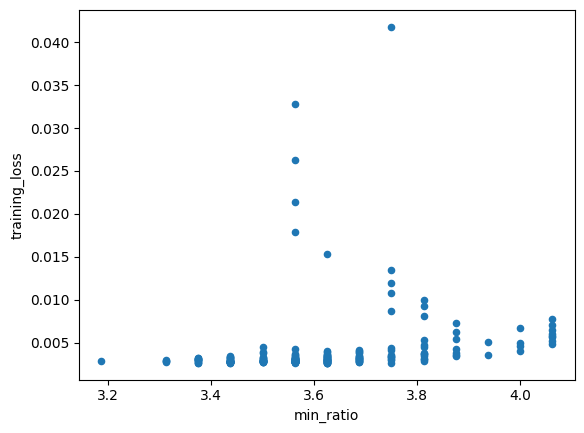

In [7]:
final_df.plot.scatter(x='min_ratio', y='training_loss')

<Axes: xlabel='min_ratio', ylabel='gradient'>

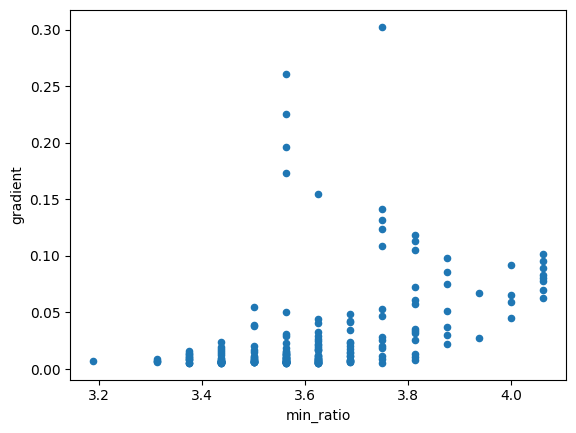

In [8]:
final_df.plot.scatter(x='min_ratio', y='gradient')